In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Redes Neurais: Problemas de Classificacao

Autor: Arthur Schneider Figueira

## Lendo as bibliotecas

In [2]:
import tensorflow as tf
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_columns', 25)

In [4]:
# Define a semente
seed_value = 2023
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

## Problema Binario: 2 classes

Em problemas binários, a função de ativação da última camada deve ser "sigmoid", vide:



```
# Adicione a camada de saída
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))
#O valor 1 é porque vamos retornar apenas 1 output nessa camada de saída.
```



Vamos descobrir o gênero do indivíduo, baseado em seus gostos.

Variáveis explicativas:
1. Cor Favorita;
2. Estilo de Musica Favorita;
3. Bebida alcoolica favorita;
4. Refrigerante favorito;
5. Gênero: **é nossa variável resposta**.

**Material disponivel em**: [06_gender-classification](https://www.kaggle.com/datasets/hb20007/gender-classification)

In [ ]:
df = pd.read_csv('/content/Transformed Data Set - Sheet1.csv')
df.tail()

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
61,Cool,Rock,Vodka,Coca Cola/Pepsi,M
62,Cool,Hip hop,Beer,Coca Cola/Pepsi,M
63,Neutral,Hip hop,Doesn't drink,Fanta,M
64,Cool,Rock,Wine,Coca Cola/Pepsi,M
65,Cool,Electronic,Beer,Coca Cola/Pepsi,M


In [ ]:
df.Gender.unique() #Ha duas classes: F (female/feminino) e M (male/masculino)

array(['F', 'M'], dtype=object)

In [ ]:
dict(df.Gender.value_counts()) #A base esta balanceada

{'F': 33, 'M': 33}

In [ ]:
for col in list(df.columns):
  print(col,df[col].nunique())

Favorite Color 3
Favorite Music Genre 7
Favorite Beverage 6
Favorite Soft Drink 4
Gender 2


In [ ]:
#Por serem apenas variaveis categoricas, apliquei dummificacao para a base toda
df = pd.get_dummies(df, columns = list(df.columns), dtype=float,drop_first=True)

In [ ]:
df.tail()

,Favorite Color_Neutral,Favorite Color_Warm,Favorite Music Genre_Folk/Traditional,Favorite Music Genre_Hip hop,Favorite Music Genre_Jazz/Blues,Favorite Music Genre_Pop,Favorite Music Genre_R&B and soul,Favorite Music Genre_Rock,Favorite Beverage_Doesn't drink,Favorite Beverage_Other,Favorite Beverage_Vodka,Favorite Beverage_Whiskey,Favorite Beverage_Wine,Favorite Soft Drink_Coca Cola/Pepsi,Favorite Soft Drink_Fanta,Favorite Soft Drink_Other,Gender_M
61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
62,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
63,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
X = df.drop(columns = ['Gender_M'])
y = df.Gender_M
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=26, random_state=2023,stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=10, random_state=2023,stratify=y_test)

#Com o parametro stratify, a divisao das bases mantera uma qt equilibrada de M e F

In [ ]:
print(f" Treino {len(X_train)}, Teste {len(X_test)}, Validacao {len(X_val)}")

 Treino 40, Teste 16, Validacao 10


## Modelagem

### Parametros da Rede Neural

* Early Stopping

In [21]:
# Incluindo early stopping

# Defina o callback EarlyStopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',  # Métrica a ser monitorada
    patience=50,          # Número de épocas sem melhoria antes de parar o treinamento
    restore_best_weights=True  # Restaura os melhores pesos encontrados durante o treinamento
)

* Learning Rate

In [22]:
# Definindo a função para agendar o learning rate
def lr_scheduler(epoch):
    if epoch < 50:
        return 0.005
    elif epoch < 100:
        return 0.001
    elif epoch < 150:
        return 0.0005
    else:
        return 0.0001

# Criando o callback para o Learning Rate Scheduler
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Optei por alterar o learning rate a cada 50 epocas,
# pois o early stop vai encerrar o treinamento quando 50 epocas se passarem sem melhorar o modelo.

Lembrete: esses parâmetros (early stopping e learning rate) são utilizados como callbacks:



```
# Treinando o modelo
model.fit(X_train, y_train, epochs=200, batch_size=16, callbacks=[lr_scheduler_callback,early_stopping_callback])
```



### Otimizador: SGD

[Documentacao](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/SGD)

In [ ]:
# Crie o modelo sequencial
model1 = tf.keras.models.Sequential() #Definimos que é um modelo de rede neural sequencial

# Adicione a primeira camada oculta
model1.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],))) #Adicionamos a primeira camada que recebe os inputs e terá 2 neurônios

# Adicione a segunda camada oculta
model1.add(tf.keras.layers.Dense(256, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a terceira camada oculta
model1.add(tf.keras.layers.Dense(512, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quarta camada oculta
model1.add(tf.keras.layers.Dense(512, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model1.add(tf.keras.layers.Dense(256, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model1.add(tf.keras.layers.Dense(128, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model1.add(tf.keras.layers.Dense(64, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a camada de saída
model1.add(tf.keras.layers.Dense(1, activation='sigmoid')) #O valor 1 é porque vamos retornar apenas 1 output nessa camada de saída.

# Compila o modelo
model1.compile(optimizer=tf.keras.optimizers.SGD(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2176      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8

In [ ]:
history1 = model1.fit(X_train.values, np.array(y_train), epochs=200, batch_size=int(0.25*len(X)), verbose=1,
                    callbacks=[early_stopping_callback,lr_scheduler_callback],
                    validation_data=(X_test.values, np.array(y_test))
                    )

Epoch 1/200
3/3 [==============================] - 5s 400ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6923 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 2/200
3/3 [==============================] - 0s 71ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6922 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 3/200
3/3 [==============================] - 0s 103ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6922 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 4/200
3/3 [==============================] - 0s 72ms/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.6922 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 5/200
3/3 [==============================] - 0s 105ms/step - loss: 0.6929 - accuracy: 0.5000 - val_loss: 0.6922 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 6/200
3/3 [==============================] - 0s 88ms/step - loss: 0.6927 - accuracy: 0.5000 - val_loss: 0.6922 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 7/200
3/3 [==============================] - 0s 66ms/step - loss: 0.6926 

In [ ]:
# Acessando o histórico de treinamento para visualizar a perda no conjunto de treinamento e no conjunto de teste
train_loss1 = history1.history['loss']
test_loss1 = history1.history['val_loss']

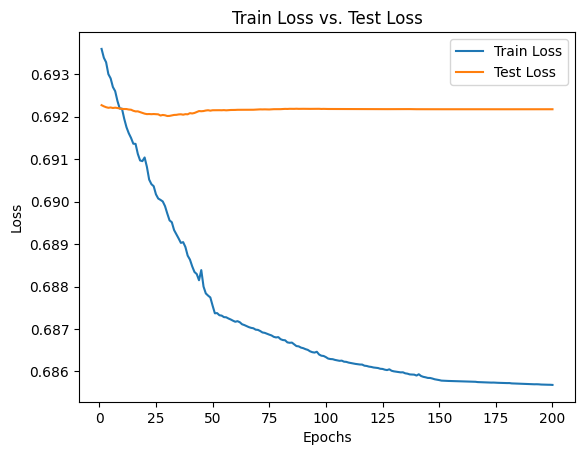

In [ ]:
# Plotando o gráfico comparativo
epochs = range(1, len(train_loss1) + 1)
plt.plot(epochs, train_loss1, label='Train Loss')
plt.plot(epochs, test_loss1, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs. Test Loss')
plt.legend()
plt.show()

### Otimizador: Adam

[Documentacao](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

Epoch 1/200
3/3 [==============================] - 2s 134ms/step - loss: 0.7258 - accuracy: 0.5000 - val_loss: 0.6940 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 2/200
3/3 [==============================] - 0s 48ms/step - loss: 0.6873 - accuracy: 0.5000 - val_loss: 0.7100 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 3/200
3/3 [==============================] - 0s 34ms/step - loss: 0.6752 - accuracy: 0.5250 - val_loss: 0.7785 - val_accuracy: 0.4375 - lr: 0.0050
Epoch 4/200
3/3 [==============================] - 0s 40ms/step - loss: 0.6458 - accuracy: 0.6250 - val_loss: 0.8631 - val_accuracy: 0.4375 - lr: 0.0050
Epoch 5/200
3/3 [==============================] - 0s 44ms/step - loss: 0.4619 - accuracy: 0.8250 - val_loss: 1.2150 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 6/200
3/3 [==============================] - 0s 40ms/step - loss: 0.3506 - accuracy: 0.8500 - val_loss: 2.4292 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 7/200
3/3 [==============================] - 0s 40ms/step - loss: 0.2239 - 

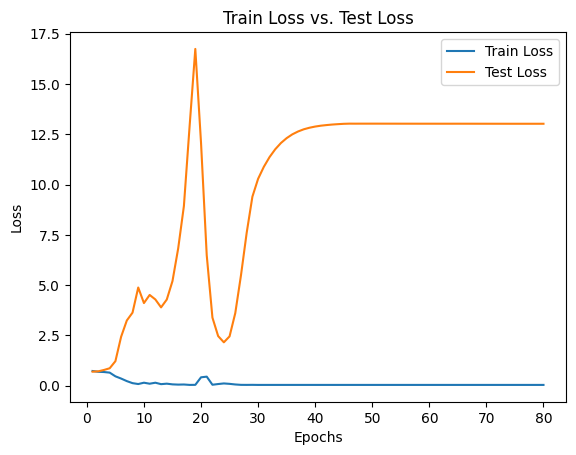

In [ ]:
# Crie o modelo sequencial
model2 = tf.keras.models.Sequential() #Definimos que é um modelo de rede neural sequencial

# Adicione a primeira camada oculta
model2.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],))) #Adicionamos a primeira camada que recebe os inputs e terá 2 neurônios

# Adicione a segunda camada oculta
model2.add(tf.keras.layers.Dense(256, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a terceira camada oculta
model2.add(tf.keras.layers.Dense(512, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quarta camada oculta
model2.add(tf.keras.layers.Dense(512, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model2.add(tf.keras.layers.Dense(256, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model2.add(tf.keras.layers.Dense(128, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model2.add(tf.keras.layers.Dense(64, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a camada de saída
model2.add(tf.keras.layers.Dense(1, activation='sigmoid')) #O valor 1 é porque vamos retornar apenas 1 output nessa camada de saída.

# Compila o modelo
model2.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history2 = model2.fit(X_train.values, np.array(y_train), epochs=200, batch_size=int(0.25*len(X)), verbose=1,
                    callbacks=[early_stopping_callback,lr_scheduler_callback],
                    validation_data=(X_test.values, np.array(y_test))
                    )
# Acessando o histórico de treinamento para visualizar a perda no conjunto de treinamento e no conjunto de teste
train_loss2 = history2.history['loss']
test_loss2 = history2.history['val_loss']

# Plotando o gráfico comparativo
epochs = range(1, len(train_loss2) + 1)
plt.plot(epochs, train_loss2, label='Train Loss')
plt.plot(epochs, test_loss2, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs. Test Loss')
plt.legend()
plt.show()

### Otimizador RMSprop

[Documentacao](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/RMSprop)

Epoch 1/200
3/3 [==============================] - 2s 180ms/step - loss: 0.7237 - accuracy: 0.4000 - val_loss: 0.6940 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 2/200
3/3 [==============================] - 0s 45ms/step - loss: 0.6950 - accuracy: 0.4500 - val_loss: 0.6929 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 3/200
3/3 [==============================] - 0s 41ms/step - loss: 0.6996 - accuracy: 0.5250 - val_loss: 0.7187 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 4/200
3/3 [==============================] - 0s 38ms/step - loss: 0.6846 - accuracy: 0.5500 - val_loss: 0.7130 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 5/200
3/3 [==============================] - 0s 46ms/step - loss: 0.6221 - accuracy: 0.6250 - val_loss: 7.1212 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 6/200
3/3 [==============================] - 0s 40ms/step - loss: 2.3226 - accuracy: 0.7250 - val_loss: 4.0992 - val_accuracy: 0.3125 - lr: 0.0050
Epoch 7/200
3/3 [==============================] - 0s 52ms/step - loss: 0.8142 - 

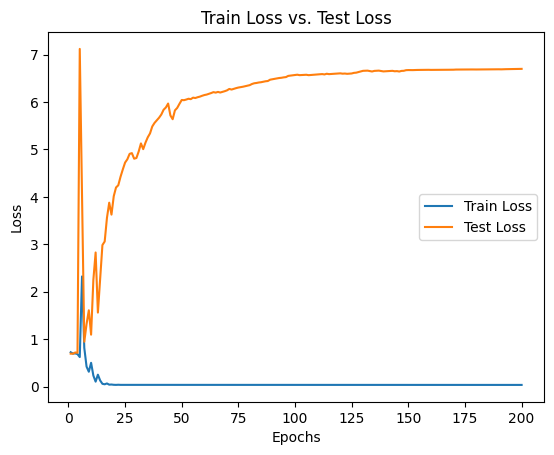

In [ ]:
# Crie o modelo sequencial
model3 = tf.keras.models.Sequential() #Definimos que é um modelo de rede neural sequencial

# Adicione a primeira camada oculta
model3.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],))) #Adicionamos a primeira camada que recebe os inputs e terá 2 neurônios

# Adicione a segunda camada oculta
model3.add(tf.keras.layers.Dense(256, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a terceira camada oculta
model3.add(tf.keras.layers.Dense(512, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quarta camada oculta
model3.add(tf.keras.layers.Dense(512, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model3.add(tf.keras.layers.Dense(256, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model3.add(tf.keras.layers.Dense(128, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model3.add(tf.keras.layers.Dense(64, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a camada de saída
model3.add(tf.keras.layers.Dense(1, activation='sigmoid')) #O valor 1 é porque vamos retornar apenas 1 output nessa camada de saída.

# Compila o modelo
model3.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])

history3 = model3.fit(X_train.values, np.array(y_train), epochs=200, batch_size=int(0.25*len(X)), verbose=1,
                    callbacks=[early_stopping_callback,lr_scheduler_callback],
                    validation_data=(X_test.values, np.array(y_test))
                    )
# Acessando o histórico de treinamento para visualizar a perda no conjunto de treinamento e no conjunto de teste
train_loss3 = history3.history['loss']
test_loss3 = history3.history['val_loss']

# Plotando o gráfico comparativo
epochs = range(1, len(train_loss3) + 1)
plt.plot(epochs, train_loss3, label='Train Loss')
plt.plot(epochs, test_loss3, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs. Test Loss')
plt.legend()
plt.show()

### Otimizador: Adagrad

[Documentacao](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/Adagrad)

Epoch 1/200
3/3 [==============================] - 1s 133ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6927 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 2/200
3/3 [==============================] - 0s 38ms/step - loss: 0.6929 - accuracy: 0.5000 - val_loss: 0.6926 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 3/200
3/3 [==============================] - 0s 36ms/step - loss: 0.6927 - accuracy: 0.4500 - val_loss: 0.6926 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 4/200
3/3 [==============================] - 0s 43ms/step - loss: 0.6922 - accuracy: 0.5000 - val_loss: 0.6925 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 5/200
3/3 [==============================] - 0s 32ms/step - loss: 0.6919 - accuracy: 0.5000 - val_loss: 0.6924 - val_accuracy: 0.7500 - lr: 0.0050
Epoch 6/200
3/3 [==============================] - 0s 31ms/step - loss: 0.6915 - accuracy: 0.4500 - val_loss: 0.6924 - val_accuracy: 0.5625 - lr: 0.0050
Epoch 7/200
3/3 [==============================] - 0s 34ms/step - loss: 0.6912 - 

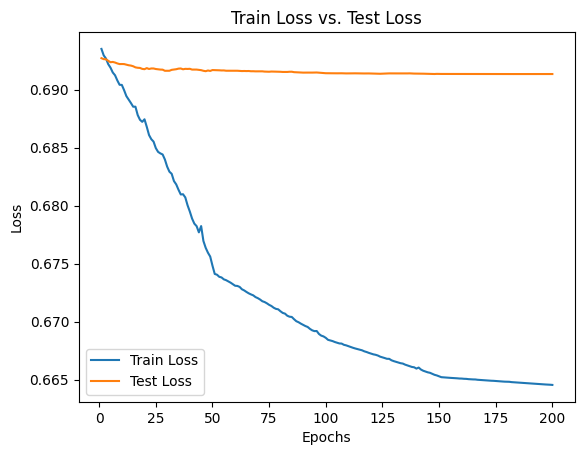

In [ ]:
# Crie o modelo sequencial
model4 = tf.keras.models.Sequential() #Definimos que é um modelo de rede neural sequencial

# Adicione a primeira camada oculta
model4.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],))) #Adicionamos a primeira camada que recebe os inputs e terá 2 neurônios

# Adicione a segunda camada oculta
model4.add(tf.keras.layers.Dense(256, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a terceira camada oculta
model4.add(tf.keras.layers.Dense(512, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quarta camada oculta
model4.add(tf.keras.layers.Dense(512, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model4.add(tf.keras.layers.Dense(256, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model4.add(tf.keras.layers.Dense(128, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model4.add(tf.keras.layers.Dense(64, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a camada de saída
model4.add(tf.keras.layers.Dense(1, activation='sigmoid')) #O valor 1 é porque vamos retornar apenas 1 output nessa camada de saída.

# Compila o modelo
model4.compile(optimizer=tf.keras.optimizers.Adagrad(), loss='binary_crossentropy', metrics=['accuracy'])

history4 = model4.fit(X_train.values, np.array(y_train), epochs=200, batch_size=int(0.25*len(X)), verbose=1,
                    callbacks=[early_stopping_callback,lr_scheduler_callback],
                    validation_data=(X_test.values, np.array(y_test))
                    )
# Acessando o histórico de treinamento para visualizar a perda no conjunto de treinamento e no conjunto de teste
train_loss4 = history4.history['loss']
test_loss4 = history4.history['val_loss']

# Plotando o gráfico comparativo
epochs = range(1, len(train_loss4) + 1)
plt.plot(epochs, train_loss4, label='Train Loss')
plt.plot(epochs, test_loss4, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs. Test Loss')
plt.legend()
plt.show()

### Otimizador: Ada Delta

[Documentacao](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/Adadelta)

Epoch 1/200
3/3 [==============================] - 2s 120ms/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.6914 - val_accuracy: 0.6250 - lr: 0.0050
Epoch 2/200
3/3 [==============================] - 0s 30ms/step - loss: 0.6928 - accuracy: 0.5000 - val_loss: 0.6914 - val_accuracy: 0.6250 - lr: 0.0050
Epoch 3/200
3/3 [==============================] - 0s 30ms/step - loss: 0.6927 - accuracy: 0.5000 - val_loss: 0.6914 - val_accuracy: 0.6250 - lr: 0.0050
Epoch 4/200
3/3 [==============================] - 0s 30ms/step - loss: 0.6925 - accuracy: 0.5250 - val_loss: 0.6914 - val_accuracy: 0.6250 - lr: 0.0050
Epoch 5/200
3/3 [==============================] - 0s 29ms/step - loss: 0.6924 - accuracy: 0.5500 - val_loss: 0.6914 - val_accuracy: 0.6250 - lr: 0.0050
Epoch 6/200
3/3 [==============================] - 0s 30ms/step - loss: 0.6923 - accuracy: 0.5250 - val_loss: 0.6914 - val_accuracy: 0.6250 - lr: 0.0050
Epoch 7/200
3/3 [==============================] - 0s 33ms/step - loss: 0.6921 - 

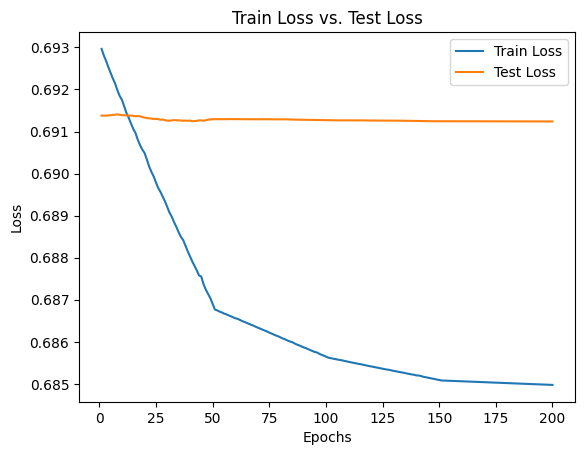

In [ ]:
# Crie o modelo sequencial
model5 = tf.keras.models.Sequential() #Definimos que é um modelo de rede neural sequencial

# Adicione a primeira camada oculta
model5.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],))) #Adicionamos a primeira camada que recebe os inputs e terá 2 neurônios

# Adicione a segunda camada oculta
model5.add(tf.keras.layers.Dense(256, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a terceira camada oculta
model5.add(tf.keras.layers.Dense(512, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quarta camada oculta
model5.add(tf.keras.layers.Dense(512, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model5.add(tf.keras.layers.Dense(256, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model5.add(tf.keras.layers.Dense(128, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model5.add(tf.keras.layers.Dense(64, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a camada de saída
model5.add(tf.keras.layers.Dense(1, activation='sigmoid')) #O valor 1 é porque vamos retornar apenas 1 output nessa camada de saída.

# Compila o modelo
model5.compile(optimizer=tf.keras.optimizers.Adadelta(), loss='binary_crossentropy', metrics=['accuracy'])

history5 = model5.fit(X_train.values, np.array(y_train), epochs=200, batch_size=int(0.25*len(X)), verbose=1,
                    callbacks=[early_stopping_callback,lr_scheduler_callback],
                    validation_data=(X_test.values, np.array(y_test))
                    )
# Acessando o histórico de treinamento para visualizar a perda no conjunto de treinamento e no conjunto de teste
train_loss5 = history5.history['loss']
test_loss5 = history5.history['val_loss']

# Plotando o gráfico comparativo
epochs = range(1, len(train_loss5) + 1)
plt.plot(epochs, train_loss5, label='Train Loss')
plt.plot(epochs, test_loss5, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs. Test Loss')
plt.legend()
plt.show()

### Otimizador: N Adam

[Documentacao](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/Nadam)

Epoch 1/200
3/3 [==============================] - 4s 192ms/step - loss: 0.7049 - accuracy: 0.4250 - val_loss: 0.6936 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 2/200
3/3 [==============================] - 0s 42ms/step - loss: 0.6843 - accuracy: 0.5250 - val_loss: 0.6985 - val_accuracy: 0.4375 - lr: 0.0050
Epoch 3/200
3/3 [==============================] - 0s 46ms/step - loss: 0.6013 - accuracy: 0.6750 - val_loss: 2.2448 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 4/200
3/3 [==============================] - 0s 42ms/step - loss: 1.2965 - accuracy: 0.5750 - val_loss: 0.7498 - val_accuracy: 0.6250 - lr: 0.0050
Epoch 5/200
3/3 [==============================] - 0s 42ms/step - loss: 0.4830 - accuracy: 0.8000 - val_loss: 2.3793 - val_accuracy: 0.3750 - lr: 0.0050
Epoch 6/200
3/3 [==============================] - 0s 42ms/step - loss: 0.2819 - accuracy: 0.8500 - val_loss: 3.3199 - val_accuracy: 0.4375 - lr: 0.0050
Epoch 7/200
3/3 [==============================] - 0s 47ms/step - loss: 0.2065 - 

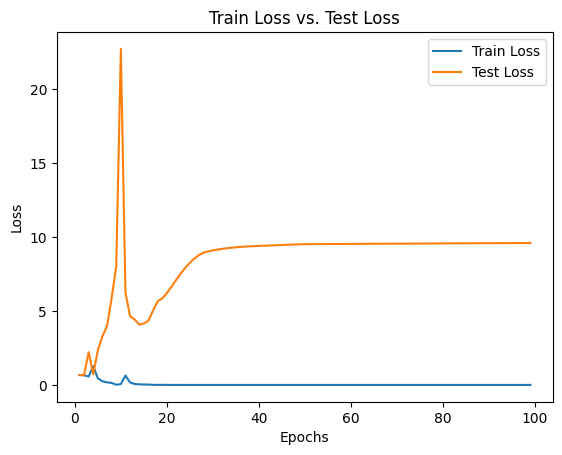

In [ ]:
# Crie o modelo sequencial
model6 = tf.keras.models.Sequential() #Definimos que é um modelo de rede neural sequencial

# Adicione a primeira camada oculta
model6.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],))) #Adicionamos a primeira camada que recebe os inputs e terá 2 neurônios

# Adicione a segunda camada oculta
model6.add(tf.keras.layers.Dense(256, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a terceira camada oculta
model6.add(tf.keras.layers.Dense(512, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quarta camada oculta
model6.add(tf.keras.layers.Dense(512, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model6.add(tf.keras.layers.Dense(256, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model6.add(tf.keras.layers.Dense(128, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model6.add(tf.keras.layers.Dense(64, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a camada de saída
model6.add(tf.keras.layers.Dense(1, activation='sigmoid')) #O valor 1 é porque vamos retornar apenas 1 output nessa camada de saída.

# Compila o modelo
model6.compile(optimizer=tf.keras.optimizers.Nadam(), loss='binary_crossentropy', metrics=['accuracy'])

history6 = model6.fit(X_train.values, np.array(y_train), epochs=200, batch_size=int(0.25*len(X)), verbose=1,
                    callbacks=[early_stopping_callback,lr_scheduler_callback],
                    validation_data=(X_test.values, np.array(y_test))
                    )
# Acessando o histórico de treinamento para visualizar a perda no conjunto de treinamento e no conjunto de teste
train_loss6 = history6.history['loss']
test_loss6 = history6.history['val_loss']

# Plotando o gráfico comparativo
epochs = range(1, len(train_loss6) + 1)
plt.plot(epochs, train_loss6, label='Train Loss')
plt.plot(epochs, test_loss6, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs. Test Loss')
plt.legend()
plt.show()

### Avaliando os modelos

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
[float(x) for x in model1.predict(X_val)]

1/1 [==============================] - 0s 50ms/step


[0.49072399735450745,
 0.48972421884536743,
 0.48242658376693726,
 0.4928223192691803,
 0.4906209707260132,
 0.4834696352481842,
 0.49197524785995483,
 0.486756831407547,
 0.4844234585762024,
 0.495567262172699]

In [ ]:
transforma_bin = lambda x: 1 if x > 0.5 else 0

1/1 [==============================] - 0s 39ms/step


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
print('SGD',accuracy_score(y_val, [transforma_bin(float(x)) for x in model1.predict(X_val)]))
print('Adam',accuracy_score(y_val, [transforma_bin(float(x)) for x in model2.predict(X_val)]))
print('RMSProp',accuracy_score(y_val, [transforma_bin(float(x)) for x in model3.predict(X_val)]))
print('Ada Grad',accuracy_score(y_val, [transforma_bin(float(x)) for x in model4.predict(X_val)]))
print('Ada Delta',accuracy_score(y_val, [transforma_bin(float(x)) for x in model5.predict(X_val)]))
print('N Adam',accuracy_score(y_val, [transforma_bin(float(x)) for x in model6.predict(X_val)]))

1/1 [==============================] - 0s 48ms/step
SGD 0.5
1/1 [==============================] - 0s 216ms/step
Adam 0.8
1/1 [==============================] - 0s 182ms/step
RMSProp 0.7
1/1 [==============================] - 0s 166ms/step
Ada Grad 0.6


1/1 [==============================] - 0s 408ms/step
Ada Delta 0.7


1/1 [==============================] - 0s 225ms/step
N Adam 0.6


In [ ]:
print('Adam: teste',accuracy_score(y_test, [transforma_bin(float(x)) for x in model2.predict(X_test)]))
print('Adam: treino',accuracy_score(y_train, [transforma_bin(float(x)) for x in model2.predict(X_train)]))

1/1 [==============================] - 0s 25ms/step
Adam: teste 0.5625
2/2 [==============================] - 0s 8ms/step
Adam: treino 0.975


In [ ]:
print('Ada Delta: validacao',accuracy_score(y_val, [transforma_bin(float(x)) for x in model5.predict(X_val)]))
print('Ada Delta: teste',accuracy_score(y_test, [transforma_bin(float(x)) for x in model5.predict(X_test)]))
print('Ada Delta: treino',accuracy_score(y_train, [transforma_bin(float(x)) for x in model5.predict(X_train)]))

1/1 [==============================] - 0s 67ms/step
Ada Delta: validacao 0.7
1/1 [==============================] - 0s 102ms/step
Ada Delta: teste 0.6875
2/2 [==============================] - 0s 13ms/step
Ada Delta: treino 0.75


### Conclusao
* Adam: Por mais que o modelo com o otimizador Adam tenha obtido uma maior acurácia na base de validação (dados novos), percebemos que nas bases de treino e teste, há uma variabilidade alta no resultados. Não é interessante manter um modelo que possa ser **volátil**.

* Ada Delta: já o modelo Ada Delta manteve uma acurácia em torno de 70% nas bases de treino e validação - o que já bom. E na base de treino, 75%. É normal a assertividade no treino ser maior que no teste



# Atividade

1. **(Sem Nota)** Drug 200: problema multiclasse. A base drug200.csv contém dados de saúde paciente dos pacientes e, baseado nisso, recomenda-se tomar um repectivo remédio condito na coluna Drug. Note que há 05 respostas diferentes (problema multiclasse). Portanto, sua última camada será construída como:
```
# Adicione a camada de saída
model6.add(tf.keras.layers.Dense(5, activation='softmax'))
#O valor 5 é porque vamos retornar apenas 1 output nessa camada de saída.
```
**Lembrete**: transforme cada opção num número de 1 a 5.



2. **(Com Nota)** Mushroom: problema binário. A base mushrooms.csv contém dados de **duas** espécies de cogumelos. A base está completamente criptografada e não há um dicionário.

**Projeto**:
* Testem diferentes arquiteturas para responder a esses problemas;
* Testem diferentes otimizadores;
* Dependendo da função de perda, adaptem o learning rate.

**Entrega:**
Realizem a predição da base mushrooms_AC.csv e salvem no drive da respectiva AC. Usem como nome do arquivo NOME_SOBRENOME_NOME2_SOBRENOME2.csv . Utilizem o formato padrão do pandas para exportar o arquivo.

A métrica para avaliar será a **acurácia**.

# Multiclasse

In [32]:
df_drug = pd.read_csv('/content/drive/MyDrive/Data Science/Bases/drug200.csv')
df_drug.tail()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX
199,40,F,LOW,NORMAL,11.349,drugX


In [33]:
df_drug.Drug.nunique()

5

In [34]:
df_drug.Drug.unique()

array(['DrugY', 'drugC', 'drugX', 'drugA', 'drugB'], dtype=object)

In [35]:
df_drug.loc[(df_drug.Drug == "drugA"), 'drugA'] = 1
df_drug.loc[(df_drug.Drug == "drugB"), 'drugB'] = 1
df_drug.loc[(df_drug.Drug == "drugC"), 'drugC'] = 1
df_drug.loc[(df_drug.Drug == "drugX"), 'drugX'] = 1
df_drug.loc[(df_drug.Drug == "DrugY"), 'DrugY'] = 1

df_drug.loc[(df_drug.drugA != 1), 'drugA'] = 0
df_drug.loc[(df_drug.drugB != 1), 'drugB'] = 0
df_drug.loc[(df_drug.drugC != 1), 'drugC'] = 0
df_drug.loc[(df_drug.drugX != 1), 'drugX'] = 0
df_drug.loc[(df_drug.DrugY != 1), 'DrugY'] = 0

In [36]:
cats_cols = ['Sex','BP','Cholesterol']
df_drug = df_drug.merge(pd.get_dummies(df_drug[cats_cols], prefix=cats_cols), left_index=True, right_index=True, how='inner')

In [37]:
df_drug.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,drugA,drugB,drugC,drugX,DrugY,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,23,F,HIGH,HIGH,25.355,DrugY,0.0,0.0,0.0,0.0,1.0,1,0,1,0,0,1,0
1,47,M,LOW,HIGH,13.093,drugC,0.0,0.0,1.0,0.0,0.0,0,1,0,1,0,1,0
2,47,M,LOW,HIGH,10.114,drugC,0.0,0.0,1.0,0.0,0.0,0,1,0,1,0,1,0
3,28,F,NORMAL,HIGH,7.798,drugX,0.0,0.0,0.0,1.0,0.0,1,0,0,0,1,1,0
4,61,F,LOW,HIGH,18.043,DrugY,0.0,0.0,0.0,0.0,1.0,1,0,0,1,0,1,0


In [38]:
X = df_drug.drop(columns = ['Sex','BP','Cholesterol','Drug','drugA','drugB','drugC','drugX','DrugY'])
y = df_drug[['drugA','drugB','drugC','drugX','DrugY']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=int(len(X)*0.3), random_state=2023,stratify=y)


In [39]:
# Crie o modelo sequencial
model_drug = tf.keras.models.Sequential() #Definimos que é um modelo de rede neural sequencial

# Adicione a primeira camada oculta
model_drug.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],))) #Adicionamos a primeira camada que recebe os inputs e terá 2 neurônios

# Adicione a segunda camada oculta
model_drug.add(tf.keras.layers.Dense(256, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a terceira camada oculta
model_drug.add(tf.keras.layers.Dense(512, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quarta camada oculta
model_drug.add(tf.keras.layers.Dense(512, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model_drug.add(tf.keras.layers.Dense(256, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model_drug.add(tf.keras.layers.Dense(128, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a quinta camada oculta
model_drug.add(tf.keras.layers.Dense(64, activation='relu')) #Adicionamos a segunda camada que terá 2 neurônios

# Adicione a camada de saída
model_drug.add(tf.keras.layers.Dense(5, activation='softmax')) #O valor 1 é porque vamos retornar apenas 1 output nessa camada de saída.

# Compila o modelo
model_drug.compile(optimizer=tf.keras.optimizers.Adadelta(), loss='categorical_crossentropy', metrics=['accuracy'])

history_model_drug = model_drug.fit(X_train.values, np.array(y_train), epochs=200, batch_size=int(0.25*len(X)), verbose=1,
                    callbacks=[early_stopping_callback,lr_scheduler_callback],
                    validation_data=(X_test.values, np.array(y_test))
                    )

Epoch 1/200
3/3 [==============================] - 2s 208ms/step - loss: 1.4500 - accuracy: 0.4571 - val_loss: 1.4168 - val_accuracy: 0.4500 - lr: 0.0050
Epoch 2/200
3/3 [==============================] - 0s 47ms/step - loss: 1.4206 - accuracy: 0.4571 - val_loss: 1.3899 - val_accuracy: 0.4500 - lr: 0.0050
Epoch 3/200
3/3 [==============================] - 0s 47ms/step - loss: 1.3933 - accuracy: 0.4571 - val_loss: 1.3664 - val_accuracy: 0.4500 - lr: 0.0050
Epoch 4/200
3/3 [==============================] - 0s 43ms/step - loss: 1.3723 - accuracy: 0.4571 - val_loss: 1.3480 - val_accuracy: 0.4500 - lr: 0.0050
Epoch 5/200
3/3 [==============================] - 0s 57ms/step - loss: 1.3540 - accuracy: 0.4571 - val_loss: 1.3315 - val_accuracy: 0.4500 - lr: 0.0050
Epoch 6/200
3/3 [==============================] - 0s 46ms/step - loss: 1.3374 - accuracy: 0.4571 - val_loss: 1.3154 - val_accuracy: 0.4500 - lr: 0.0050
Epoch 7/200
3/3 [==============================] - 0s 45ms/step - loss: 1.3219 - 

In [41]:
#Predicao
model_drug.predict(X_test.values[0:5])

1/1 [==============================] - 0s 67ms/step


array([[0.04051146, 0.03295425, 0.0411371 , 0.1267812 , 0.7586159 ],
       [0.02421253, 0.02672452, 0.03943668, 0.0783022 , 0.83132404],
       [0.09680785, 0.19870457, 0.10053334, 0.44914648, 0.15480772],
       [0.02243297, 0.01725374, 0.02216289, 0.09170368, 0.84644675],
       [0.01800559, 0.01330444, 0.01644512, 0.08605374, 0.86619115]],
      dtype=float32)

A predição é a chance para cada classe.

Considere:
```
[0.04051146, 0.03295425, 0.0411371 , 0.1267812 , 0.7586159 ]
```

Isso representa:
* Drug A  4.05% de chance;
* Drug B  3.29% de chance;
* Drug C  4.11% de chance;
* Drug X 12.67% de chance;
* Drug Y 75.86% de chance.


In [44]:
preditos = model_drug.predict(X_test.values)

2/2 [==============================] - 0s 10ms/step


In [46]:
vetor_da_vez = preditos[0]
vetor_da_vez

array([0.04051146, 0.03295425, 0.0411371 , 0.1267812 , 0.7586159 ],
      dtype=float32)

In [47]:
vetor_posicoes = np.argsort(vetor_da_vez)
vetor_posicoes

array([1, 0, 2, 3, 4])

In [52]:
DrugA_Rank = []
DrugB_Rank = []
DrugC_Rank = []
DrugX_Rank = []
DrugY_Rank = []

for vetor_da_vez in preditos:
  vetor_posicoes = np.argsort(vetor_da_vez)
  DrugA_Rank.append(vetor_posicoes[0])
  DrugB_Rank.append(vetor_posicoes[1])
  DrugC_Rank.append(vetor_posicoes[2])
  DrugX_Rank.append(vetor_posicoes[3])
  DrugY_Rank.append(vetor_posicoes[4])

In [55]:
y_test['DrugA_Rank'] = DrugA_Rank
y_test['DrugB_Rank'] = DrugB_Rank
y_test['DrugC_Rank'] = DrugC_Rank
y_test['DrugX_Rank'] = DrugX_Rank
y_test['DrugY_Rank'] = DrugY_Rank
y_test.tail()

,drugA,drugB,drugC,drugX,DrugY,DrugA_Rank,DrugB_Rank,DrugC_Rank,DrugX_Rank,DrugY_Rank
10,0.0,0.0,1.0,0.0,0.0,2,0,1,4,3
134,0.0,0.0,0.0,0.0,1.0,1,0,2,3,4
153,0.0,0.0,0.0,1.0,0.0,2,0,1,4,3
130,0.0,0.0,0.0,0.0,1.0,2,1,0,3,4
45,0.0,0.0,0.0,1.0,0.0,0,2,4,1,3


In [62]:
y_test[['DrugA_Rank','DrugB_Rank','DrugC_Rank','DrugX_Rank','DrugY_Rank']].describe()

,DrugA_Rank,DrugB_Rank,DrugC_Rank,DrugX_Rank,DrugY_Rank
count,60.000000,60.000000,60.000000,60.000000,60.000000
mean,1.133333,1.000000,1.316667,2.866667,3.683333
std,0.769474,0.882984,1.383825,0.872687,0.469102
min,0.000000,0.000000,0.000000,1.000000,3.000000
25%,1.000000,0.000000,0.000000,3.000000,3.000000
50%,1.000000,1.000000,1.000000,3.000000,4.000000
75%,2.000000,2.000000,2.000000,3.000000,4.000000
max,2.000000,2.000000,4.000000,4.000000,4.000000


In [64]:
#Validando, usando a base de teste

rankings_considerados = [4] #Indices vao de 0 a 4
for col in ['drugA','drugB','drugC','drugX','DrugY']:
  df_aux = y_test.copy()
  tradutor = {'drugA':'DrugA_Rank','drugB':'DrugB_Rank','drugC':'DrugC_Rank','drugX':'DrugX_Rank','DrugY':'DrugY_Rank'}
  df_aux.loc[(df_aux[tradutor[col]].isin(rankings_considerados)), 'Resposta'] = f'Decidiu por {col}'
  df_aux.loc[~(df_aux[tradutor[col]].isin(rankings_considerados)), 'Resposta'] = f'Não Decidiu por {col}'

  resumo = df_aux.groupby([col,'Resposta'])['Resposta'].agg(['count'])
  print(resumo,'\n---\n')

                             count
drugA Resposta                    
0.0   Não Decidiu por drugA     53
1.0   Não Decidiu por drugA      7 
---

                             count
drugB Resposta                    
0.0   Não Decidiu por drugB     55
1.0   Não Decidiu por drugB      5 
---

                             count
drugC Resposta                    
0.0   Decidiu por drugC          8
      Não Decidiu por drugC     47
1.0   Decidiu por drugC          1
      Não Decidiu por drugC      4 
---

                             count
drugX Resposta                    
0.0   Decidiu por drugX          8
      Não Decidiu por drugX     36
1.0   Decidiu por drugX          2
      Não Decidiu por drugX     14 
---

                             count
DrugY Resposta                    
0.0   Decidiu por DrugY         17
      Não Decidiu por DrugY     16
1.0   Decidiu por DrugY         24
      Não Decidiu por DrugY      3 
---



In [65]:
#Validando, usando a base de teste

rankings_considerados = [2,3,4] #Indices vao de 0 a 4
for col in ['drugA','drugB','drugC','drugX','DrugY']:
  df_aux = y_test.copy()
  tradutor = {'drugA':'DrugA_Rank','drugB':'DrugB_Rank','drugC':'DrugC_Rank','drugX':'DrugX_Rank','DrugY':'DrugY_Rank'}
  df_aux.loc[(df_aux[tradutor[col]].isin(rankings_considerados)), 'Resposta'] = f'Decidiu por {col}'
  df_aux.loc[~(df_aux[tradutor[col]].isin(rankings_considerados)), 'Resposta'] = f'Não Decidiu por {col}'

  resumo = df_aux.groupby([col,'Resposta'])['Resposta'].agg(['count'])
  print(resumo,'\n---\n')

                             count
drugA Resposta                    
0.0   Decidiu por drugA         18
      Não Decidiu por drugA     35
1.0   Decidiu por drugA          4
      Não Decidiu por drugA      3 
---

                             count
drugB Resposta                    
0.0   Decidiu por drugB         22
      Não Decidiu por drugB     33
1.0   Decidiu por drugB          1
      Não Decidiu por drugB      4 
---

                             count
drugC Resposta                    
0.0   Decidiu por drugC         22
      Não Decidiu por drugC     33
1.0   Decidiu por drugC          2
      Não Decidiu por drugC      3 
---

                             count
drugX Resposta                    
0.0   Decidiu por drugX         40
      Não Decidiu por drugX      4
1.0   Decidiu por drugX         11
      Não Decidiu por drugX      5 
---

                         count
DrugY Resposta                
0.0   Decidiu por DrugY     33
1.0   Decidiu por DrugY     27 
---



In [70]:
y_test[['drugA','drugB','drugC','drugX','DrugY']].sum()

drugA     7.0
drugB     5.0
drugC     5.0
drugX    16.0
DrugY    27.0
dtype: float64

** Conclusão **

Nesse exemplo, o modelo não foi capaz de acertar para as drogas A e B. Afinal, todos os casos que deveria recomendar tais drogas, o modelo recomendou outra.

Para as drogas Y, ele parece ter indicado corretamente. Entretanto, indicou muitas vezes Y quando o correto seria outra dropa.

Ao considerarmos que a droga correta estivesse dentre as 3 com maior probabilidade de indicação, notamos que a assertividade aumenta significativamente e que a droga Y sempre faz parte de uma dessas 3. Isso se justifica, pois a droga Y representa 45% dos dados. Portanto, o modelo acaba priorizando a recomendação da mesma.

**Maneiras de tratar:**
* Balanceando o banco de dados;
* Criando um modelo para determinar se é Dropga Y ou não; um segundo modelo para determinar se é droga X ou não; e um terceiro modelo multiclasse visto que as drogas estariam balanceadas.

# Binário

In [91]:
df_mushroom = pd.read_csv('/content/drive/MyDrive/Data Science/Bases/mushrooms.csv')
df_mushroom.tail()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
7495,x,y,e,t,n,f,c,b,w,t,b,s,s,g,p,p,w,o,p,n,v,d,e
7496,f,s,n,f,f,f,c,n,b,t,?,s,s,w,p,p,w,o,e,w,v,l,p
7497,x,f,g,f,n,f,w,b,n,t,e,s,s,w,w,p,w,o,e,n,s,g,e
7498,x,s,n,t,p,f,c,n,p,e,e,s,s,w,w,p,w,o,p,n,v,g,p
7499,x,s,n,t,p,f,c,n,w,e,e,s,s,w,w,p,w,o,p,k,s,u,p


In [ ]:
df_mushroom['class'].nunique()

2

In [76]:
len(df_mushroom)

7500